# Day 9 Analysis

Day 9 is a continuation of Day 8's analysis of WR target share vs. fantasy points for the 2022 season through Week 8. This analysis will focus on expected fanatsy points (standard scoring) given a player's average target share. To calculate expected fanatsy points scored a regression line was fit on data from 1999-2021 and then that was used on 2021 data.

I'll do some exploratory analysis on expected fanatsy points scored and the difference between a player's actual fantasy points and expected fanatsy points which I will call point differential or `point_diff`. I want to see the probability of a player with X point differential to see how likely that player is to regress positively or negatively towards his expected points.

A positive regression candidate is a "buy low" player and a negative regression candidate is a "sell high" player.

## Set Up

In [165]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. Fantasy Points: 1999-2011
First I'll get the average target share and fanatsy points scored by WR for seasons 1999-2021. Then I'll fit a regression line to the data which will be used to generate expected fanatsy points for the 2022 season.

### Get Data

In [215]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points AS fantasy_pts,
        fantasy_points_ppr AS fantasy_pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(fantasy_pts) AS avg_fantasy_pts,
        AVG(fantasy_pts_ppr) AS avg_fantasy_pts_ppr
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_1999_2021 = pd.read_sql(query, conn)
print(df_by_player_1999_2021.shape)
df_by_player_1999_2021.head()


(1170, 5)


,player_name,num_games,avg_tgt_share,avg_fantasy_pts,avg_fantasy_pts_ppr
0,Derrick Alexander,52,0.199942,7.315385,10.526923
1,Brian Alford,2,0.057958,3.350000,3.850000
2,Reidel Anthony,36,0.121562,2.800000,4.411111
3,Justin Armour,14,0.173866,5.014286,7.371429
4,Karsten Bailey,9,0.076829,1.644444,2.644444


### Clean Data

In [216]:
# Check for number of games played
# If number of game played = 1, can create noise. Will want to remove
print(df_by_player_1999_2021['num_games'].value_counts(normalize=True).sort_index()[:4].sum())
df_by_player_1999_2021['num_games'].value_counts(normalize=True).sort_index()[:10]

0.23333333333333334


1     0.096581
2     0.058974
3     0.045299
4     0.032479
5     0.025641
6     0.021368
7     0.029915
8     0.024786
9     0.015385
10    0.013675
Name: num_games, dtype: float64

I'll remove players with only 1 game played since those can definitely create some noise in the data. Based on normalized values I'd like to take players that have at least 5 games played but that would mean removing almost 25% of the data so I'll leave players with 2+ games in the dataset.

In [217]:
df_by_player_1999_2021 = df_by_player_1999_2021[df_by_player_1999_2021['num_games'] > 1]
print(df_by_player_1999_2021.shape)

(1057, 5)


### Exploratory Analysis

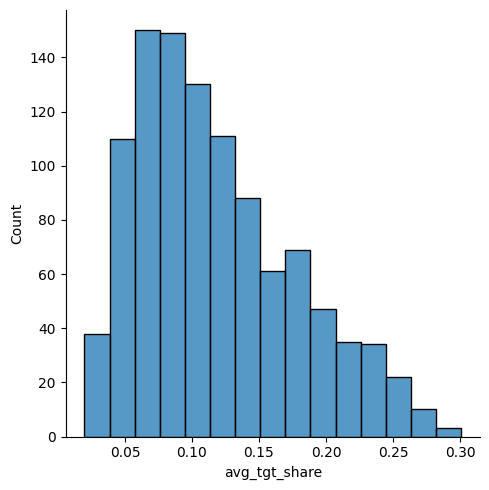

In [218]:
# Check distribution
sns.displot(
    x="avg_tgt_share",
    data=df_by_player_1999_2021,
    kind="hist",
    bins = 15
)

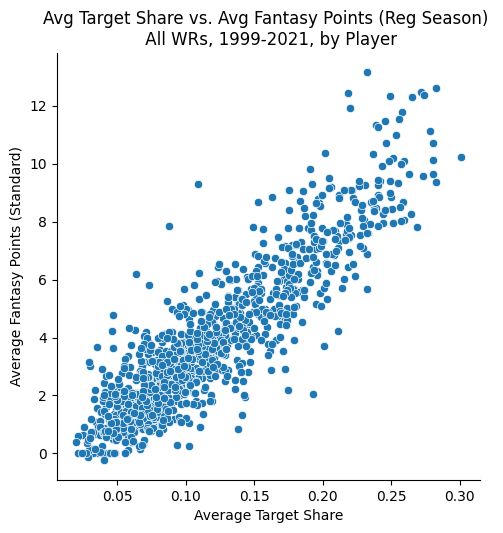

In [219]:
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_fantasy_pts",
    data=df_by_player_1999_2021
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Average Fantasy Points (Standard)",
    title="Avg Target Share vs. Avg Fantasy Points (Reg Season) \n All WRs, 1999-2021, by Player"
)

In [220]:
print(f"Correlation Coefficient: {df_by_player_1999_2021['avg_tgt_share'].corr(df_by_player_1999_2021['avg_fantasy_pts'])}")

Correlation Coefficient: 0.8935066509956594


I'll group by player to smooth out the variance and verify that the relationship holds over the course of a season and a player's career

In [128]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        receptions,
        targets,
        (1.0 * receptions/targets) AS tgt_conv,
        receiving_yards AS yds,
        receiving_tds AS tds,
        receiving_air_yards AS air_yds,
        receiving_yards_after_catch AS yac,
        target_share AS tgt_share,
        air_yards_share AS air_yds_share,
        fantasy_points AS fantasy_pts,
        fantasy_points_ppr AS fantasy_pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
), aggregation AS (
    SELECT
        player_id,
        player_name,
        COUNT(*) AS num_games,
        AVG(receptions) AS avg_receptions,
        AVG(targets) AS avg_targets,
        AVG(tgt_conv) AS avg_tgt_conv,
        AVG(yds) AS avg_yds,
        AVG(tds) AS avg_tds,
        AVG(air_yds) AS avg_air_yds,
        AVG(yac) AS avg_yac,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(air_yds_share) AS avg_air_yds_share,
        AVG(fantasy_pts) AS avg_fantasy_pts,
        AVG(fantasy_pts_ppr) AS avg_fantasy_pts_ppr
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_avg_sql = pd.read_sql(query, conn)

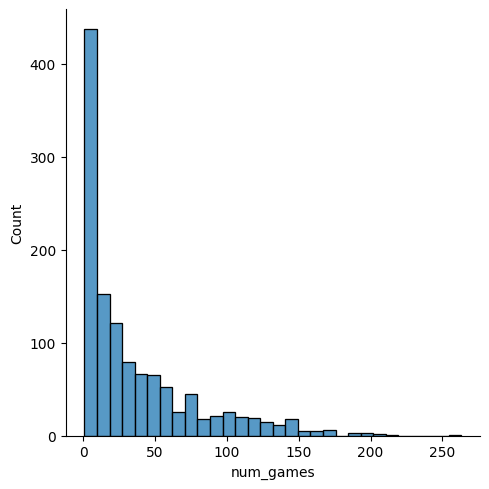

In [129]:
sns.displot(
    x='num_games',
    data=df_avg_sql,
    kind="hist"
)

In [130]:
print(df_avg_sql['num_games'].value_counts(normalize=True).sort_index()[:4].sum())
df_avg_sql['num_games'].value_counts(normalize=True).sort_index()[:10]

0.238290879211175


1     0.096138
2     0.063270
3     0.043550
4     0.035333
5     0.023829
6     0.023829
7     0.026294
8     0.032046
9     0.014790
10    0.011504
Name: num_games, dtype: float64

Let's remove players with only 1 game played since those can definitely create some noise in the data. Based on normalized values I'd like to take players that have at least 5 games played but that would mean removing almost 25% of the data.

(1100, 14)


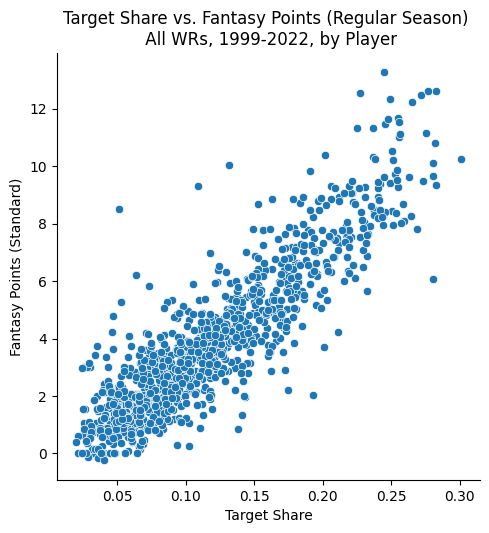

In [131]:
# Filter out players with only 1 game played
only_one_game = (df_avg_sql['num_games'] == 1)

# Print number of player records
print(df_avg_sql[~only_one_game].shape)

# Plot
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_fantasy_pts",
    data=df_avg_sql[~only_one_game]
)

g.set(
    xlabel="Target Share", 
    ylabel="Fantasy Points (Standard)",
    title="Target Share vs. Fantasy Points (Regular Season) \n All WRs, 1999-2022, by Player"
)

In [132]:
print(f"Correlation Coefficient: {round(df_avg_sql[~only_one_game]['avg_tgt_share'].corr(df_avg_sql[~only_one_game]['avg_fantasy_pts']),3)}")

Correlation Coefficient: 0.889


In [133]:
df_all.columns

Index(['player_id', 'player_name', 'season', 'week', 'receptions', 'targets',
       'tgt_conv', 'yds', 'tds', 'air_yds', 'yac', 'tgt_share',
       'air_yds_share', 'fantasy_pts', 'fantasy_pts_ppr'],
      dtype='object')

Player recrods: (1217, 14)


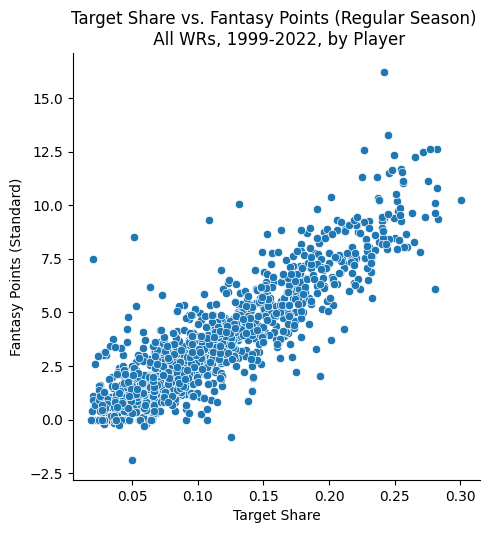

In [134]:
# Define aggregations
aggregations = {
    'season':'count', # number of games played
    'receptions':'mean',
    'targets':'mean',
    'tgt_conv':'mean',
    'yds':'mean',
    'tds':'mean',
    'air_yds':'mean',
    'yac':'mean',
    'tgt_share':'mean',
    'air_yds_share':'mean',
    'fantasy_pts':'mean',
    'fantasy_pts_ppr':'mean'
}

# Aggregate and validate number of records
df_avg = df_all.groupby(['player_id', 'player_name']).agg(aggregations).reset_index()
print(f"Player recrods: {df_avg.shape}")

# Plot
g = sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_avg
)

g.set(
    xlabel="Target Share", 
    ylabel="Fantasy Points (Standard)",
    title="Target Share vs. Fantasy Points (Regular Season) \n All WRs, 1999-2022, by Player"
)

In [135]:
print(f"Correlation Coefficient: {round(df_avg['tgt_share'].corr(df_avg['fantasy_pts']),3)}")

Correlation Coefficient: 0.885


A correlation coefficient of 0.89 shows a very strong positive correlation between a player's average air yards and average fantasy points over their career.

In [136]:
# Cleaning
df_avg.rename(columns = {
    'season':'num_games',
    'receptions':'avg_receptions',
    'targets':'avg_targets', 
    'yds':'avg_yds', 
    'tds':'avg_tds',
    'air_yds':'avg_air_yds', 
    'yac':'avg_yac', 
    'tgt_share':'avg_tgt_share', 
    'air_yds_share':'avg_air_yds_share', 
    'fantasy_pts':'avg_fantasy_pts', 
    'fantasy_pts_ppr':'avg_fantasy_pts_ppr'
}, inplace=True)

# Remove players with only 1 game played
df_avg = df_avg[df_avg['num_games'] > 1]

# Look at the top 10 receivers by average fantasy points over their career
col_order = [
    'player_name', 'num_games', 'avg_receptions', 'avg_targets', 'avg_yds', 'avg_tds',
    'avg_air_yds', 'avg_yac', 'avg_tgt_share', 'avg_air_yds_share', 'avg_fantasy_pts', 'avg_fantasy_pts_ppr']

df_avg_final = df_avg.sort_values('avg_fantasy_pts', ascending=False).reset_index(drop=True)[col_order].round(3)

df_avg_final.head(10)


,player_name,num_games,avg_receptions,avg_targets,avg_yds,avg_tds,avg_air_yds,avg_yac,avg_tgt_share,avg_air_yds_share,avg_fantasy_pts,avg_fantasy_pts_ppr
0,Ja'Marr Chase,24,5.333,8.417,85.833,0.792,95.042,38.500,0.245,0.369,13.263,18.596
1,Justin Jefferson,40,6.200,9.075,94.200,0.475,101.925,31.675,0.277,0.424,12.625,18.825
2,Marvin Harrison,146,6.192,8.699,82.664,0.733,12.192,3.610,0.282,0.065,12.609,18.801
3,Tyreek Hill,99,5.535,8.081,76.677,0.586,95.828,27.293,0.227,0.337,12.561,18.096
4,Terrell Owens,170,5.371,7.971,78.582,0.747,35.535,9.371,0.271,0.170,12.489,17.860
5,Calvin Johnson,135,5.415,8.896,86.067,0.615,120.215,24.363,0.249,0.424,12.345,17.760
6,Antonio Brown,145,6.400,9.697,84.766,0.572,106.697,30.786,0.265,0.331,12.243,18.643
7,Julio Jones,147,6.020,9.395,91.340,0.422,117.986,29.463,0.255,0.380,11.675,17.695
8,Cooper Kupp,78,6.372,8.744,79.526,0.577,67.718,37.410,0.248,0.253,11.633,18.005
9,Odell Beckham,96,5.531,9.167,76.740,0.583,108.833,26.177,0.256,0.372,11.536,17.067


In [137]:
df_avg_sql.sort_values('avg_fantasy_pts', ascending=False).head(10)

,player_id,player_name,num_games,avg_receptions,avg_targets,avg_tgt_conv,avg_yds,avg_tds,avg_air_yds,avg_yac,avg_tgt_share,avg_air_yds_share,avg_fantasy_pts,avg_fantasy_pts_ppr
1121,00-0036183,Kristian Wilkerson,1,4.000000,8.000000,0.500000,42.000000,2.000000,132.000000,5.000000,0.242424,0.534413,16.200001,20.200001
1175,00-0036900,Ja'Marr Chase,24,5.333333,8.416667,0.629874,85.833333,0.791667,95.041667,38.500000,0.244770,0.369264,13.262500,18.595833
448,00-0024148,Cory Ross,1,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,13.200000,13.200000
1137,00-0036322,Justin Jefferson,40,6.200000,9.075000,0.686439,94.200000,0.475000,101.925000,31.675000,0.276995,0.424437,12.625500,18.825500
69,00-0007024,Marvin Harrison,146,6.191781,8.698630,0.757151,82.664384,0.732877,12.191781,3.609589,0.282374,0.065128,12.608904,18.800685
929,00-0033040,Tyreek Hill,99,5.535354,8.080808,0.689627,76.676768,0.585859,95.828283,27.292929,0.227002,0.337072,12.560606,18.095960
135,00-0012478,Terrell Owens,170,5.370588,7.970588,0.715073,78.582353,0.747059,35.535294,9.370588,0.271462,0.169944,12.489412,17.860000
482,00-0025389,Calvin Johnson,135,5.414815,8.896296,0.675657,86.066667,0.614815,120.214815,24.362963,0.249301,0.423850,12.345185,17.760000
629,00-0027793,Antonio Brown,145,6.400000,9.696552,0.667820,84.765517,0.572414,106.696552,30.786207,0.265420,0.330902,12.243448,18.643448
641,00-0027944,Julio Jones,147,6.020408,9.394558,0.642261,91.340136,0.421769,117.986395,29.462585,0.254901,0.379678,11.674830,17.695238


In [138]:
# Now order by average target share
df_avg_final.sort_values('avg_tgt_share', ascending=False).head(10)

,player_name,num_games,avg_receptions,avg_targets,avg_yds,avg_tds,avg_air_yds,avg_yac,avg_tgt_share,avg_air_yds_share,avg_fantasy_pts,avg_fantasy_pts_ppr
21,Jimmy Smith,107,5.579,8.972,77.093,0.421,0.000,0.000,0.301,0.000,10.232,15.811
37,Rod Smith,125,5.336,8.112,68.464,0.376,2.936,1.144,0.283,0.027,9.356,14.692
16,DeAndre Hopkins,138,5.877,9.413,78.572,0.500,111.928,20.993,0.282,0.386,10.810,16.687
2,Marvin Harrison,146,6.192,8.699,82.664,0.733,12.192,3.610,0.282,0.065,12.609,18.801
207,Drake London,8,3.750,6.125,43.250,0.250,61.500,13.750,0.280,0.288,6.075,9.825
28,Andre Johnson,190,5.589,8.247,74.658,0.368,68.258,19.495,0.280,0.260,9.652,15.242
23,Brandon Marshall,171,5.673,8.702,72.228,0.485,96.351,21.310,0.280,0.367,10.122,15.795
1,Justin Jefferson,40,6.200,9.075,94.200,0.475,101.925,31.675,0.277,0.424,12.625,18.825
13,Michael Thomas,73,7.205,9.301,83.849,0.479,79.110,28.822,0.275,0.360,11.141,18.347
32,Steve Smith,215,4.795,7.177,68.498,0.377,59.721,17.479,0.273,0.266,9.476,14.272


## Air Yards vs. Fantasy Points: 2022

In [139]:
# Get the top 10 WRs by average fantasy points for the 2022 season
f_2022 = df_all['season'] == 2022

df_2022 = df_all[f_2022].groupby(['player_id', 'player_name']).agg(aggregations).reset_index()
print(f"WRs in 2022: {df_2022.shape}")

# Cleaning
df_2022.rename(columns = {
    'season':'num_games',
    'receptions':'avg_receptions',
    'targets':'avg_targets', 
    'yds':'avg_yds', 
    'tds':'avg_tds',
    'air_yds':'avg_air_yds', 
    'yac':'avg_yac', 
    'tgt_share':'avg_tgt_share', 
    'air_yds_share':'avg_air_yds_share', 
    'fantasy_pts':'avg_fantasy_pts', 
    'fantasy_pts_ppr':'avg_fantasy_pts_ppr'
}, inplace=True)

# Remove players with only 1 game played
df_2022 = df_2022[df_2022['num_games'] > 1]

# Look at the top 10 receivers by average fantasy points over their career
col_order = [
    'player_name', 'num_games', 'avg_receptions', 'avg_targets', 'avg_yds', 'avg_tds',
    'avg_air_yds', 'avg_yac', 'avg_tgt_share', 'avg_air_yds_share', 'avg_fantasy_pts', 'avg_fantasy_pts_ppr']

df_2022_final = df_2022.sort_values('avg_fantasy_pts', ascending=False).reset_index(drop=True)[col_order].round(3)
df_2022_final.index = df_2022_final.index + 1

print(f"WRs with > 1 games in 2022: {df_2022_final.shape}")
df_2022_final.head(10)



WRs in 2022: (198, 14)
WRs with > 1 games in 2022: (180, 12)


,player_name,num_games,avg_receptions,avg_targets,avg_yds,avg_tds,avg_air_yds,avg_yac,avg_tgt_share,avg_air_yds_share,avg_fantasy_pts,avg_fantasy_pts_ppr
1,Stefon Diggs,7,7.857,10.429,109.143,1.000,110.286,35.714,0.287,0.369,16.914,24.771
2,DeAndre Hopkins,2,11.000,13.500,131.000,0.500,146.500,16.000,0.392,0.584,16.100,27.100
3,Cooper Kupp,7,9.143,12.000,98.000,0.714,88.714,48.857,0.325,0.413,15.386,24.529
4,Tyreek Hill,8,8.625,11.500,120.125,0.250,132.375,37.250,0.321,0.384,13.825,22.450
5,Justin Jefferson,7,7.429,10.143,107.429,0.286,82.286,47.429,0.290,0.416,13.774,21.203
6,A.J. Brown,7,5.571,9.143,94.143,0.714,98.571,35.429,0.318,0.471,13.700,19.271
7,Ja'Marr Chase,7,6.714,10.571,86.429,0.857,94.857,39.000,0.275,0.371,13.529,20.243
8,Jaylen Waddle,8,5.250,7.875,90.875,0.625,82.625,35.250,0.217,0.267,12.800,18.050
9,Michael Thomas,3,5.333,7.333,57.000,1.000,79.000,7.000,0.201,0.195,11.700,17.033
10,Davante Adams,7,5.429,9.714,73.143,0.714,109.857,25.000,0.296,0.397,11.586,17.014


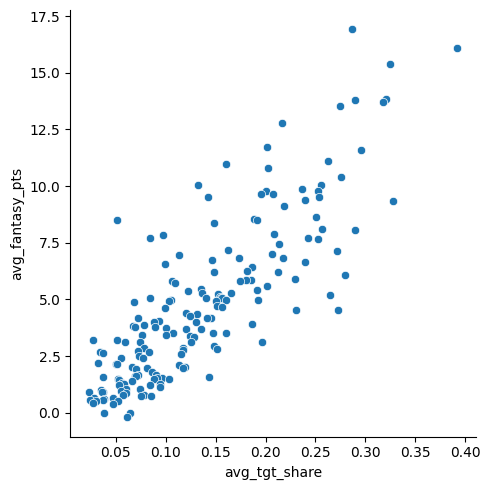

In [140]:
sns.relplot(
    x="avg_tgt_share",
    y="avg_fantasy_pts",
    data=df_2022_final
)

In [141]:
print(f"Correlation Coefficient: {round(df_2022['avg_tgt_share'].corr(df_2022['avg_fantasy_pts']),2)}")

Correlation Coefficient: 0.83


As expected the relationship between target share and fantasy points scored still holds true for 2022

In [142]:
col_order = ['player_name', 'num_games', 'avg_tgt_share', 'avg_fantasy_pts', 'avg_fantasy_pts_ppr']

df_2022_final.sort_values('avg_tgt_share', ascending=False)[col_order].head(10).round(3)

,player_name,num_games,avg_tgt_share,avg_fantasy_pts,avg_fantasy_pts_ppr
2,DeAndre Hopkins,2,0.392,16.100,27.100
25,CeeDee Lamb,8,0.328,9.350,14.600
3,Cooper Kupp,7,0.325,15.386,24.529
4,Tyreek Hill,8,0.321,13.825,22.450
6,A.J. Brown,7,0.318,13.700,19.271
10,Davante Adams,7,0.296,11.586,17.014
5,Justin Jefferson,7,0.290,13.774,21.203
33,D.J. Moore,8,0.290,8.050,12.175
1,Stefon Diggs,7,0.287,16.914,24.771
53,Drake London,8,0.280,6.075,9.825


CeeDee Lamb stands out here. He is 2nd in target share but only 25th in fantasy points scored. D.J. Moore and Drake London also stand out for similar reasons.

Given that the correlation between target share and fantasy points is so string, let's go a step further and use linear regression to get an idea of expected average fantasy points given target share. With this we can see how much each player is under or over-performing.

## Use Linear Regression to find under and over-performers through Week 8

In [143]:
# Will first need to remove NULL values to fit a regression line to the data
df_avg_final[['avg_tgt_share','avg_fantasy_pts']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_tgt_share    1099 non-null   float64
 1   avg_fantasy_pts  1100 non-null   float64
dtypes: float64(2)
memory usage: 17.3 KB


In [144]:
# Drop null values
df_avg_final = df_avg_final.dropna(subset=['avg_tgt_share', 'avg_fantasy_pts'])

# Fit a regression line
fit = np.polyfit(
    x=df_avg_final['avg_tgt_share'], 
    y=df_avg_final['avg_fantasy_pts'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [145]:
summary_2022 = df_2022_final.sort_values('avg_tgt_share', ascending=False)[col_order]

summary_2022['expected_fantasy_pts'] = lin_func_fpts(summary_2022['avg_tgt_share'])
summary_2022['perf'] = summary_2022['avg_fantasy_pts'] - summary_2022['expected_fantasy_pts']

print(summary_2022.shape)
summary_2022.head(10).round(3)


(180, 7)


,player_name,num_games,avg_tgt_share,avg_fantasy_pts,avg_fantasy_pts_ppr,expected_fantasy_pts,perf
2,DeAndre Hopkins,2,0.392,16.100,27.100,14.356,1.744
25,CeeDee Lamb,8,0.328,9.350,14.600,11.911,-2.561
3,Cooper Kupp,7,0.325,15.386,24.529,11.796,3.590
4,Tyreek Hill,8,0.321,13.825,22.450,11.643,2.182
6,A.J. Brown,7,0.318,13.700,19.271,11.529,2.171
10,Davante Adams,7,0.296,11.586,17.014,10.688,0.898
5,Justin Jefferson,7,0.290,13.774,21.203,10.459,3.315
33,D.J. Moore,8,0.290,8.050,12.175,10.459,-2.409
1,Stefon Diggs,7,0.287,16.914,24.771,10.344,6.570
53,Drake London,8,0.280,6.075,9.825,10.077,-4.002


Based on this CeeDee Lamb should be scoring about 2.5 more points per game on average!

In [150]:
# Sort by the difference between actual points and expected points to get the true "regression to the mean" candidates
summary_2022.sort_values('perf').head(10).round(3)

,player_name,num_games,avg_tgt_share,avg_fantasy_pts,avg_fantasy_pts_ppr,expected_fantasy_pts,perf
82,Darnell Mooney,8,0.273,4.550,7.675,9.810,-5.260
67,Diontae Johnson,8,0.265,5.175,10.550,9.504,-4.329
53,Drake London,8,0.280,6.075,9.825,10.077,-4.002
112,Equanimeous St. Brown,8,0.196,3.125,4.625,6.868,-3.743
83,Robert Woods,7,0.231,4.514,7.657,8.205,-3.691
142,Marcus Johnson,4,0.143,1.575,3.075,4.843,-3.268
41,Sterling Shepard,3,0.272,7.133,11.467,9.771,-2.638
93,Michael Gallup,5,0.186,3.900,6.300,6.486,-2.586
25,CeeDee Lamb,8,0.328,9.350,14.600,11.911,-2.561
33,D.J. Moore,8,0.290,8.050,12.175,10.459,-2.409


Darnell Mooney is the standout here. With almost 27% of his team's target share in 2022 he's scoring about 5.2pts less per game than he "should be" based on the observed relationship between target share and fantasy points. 

## Analyze Expected Points Differential

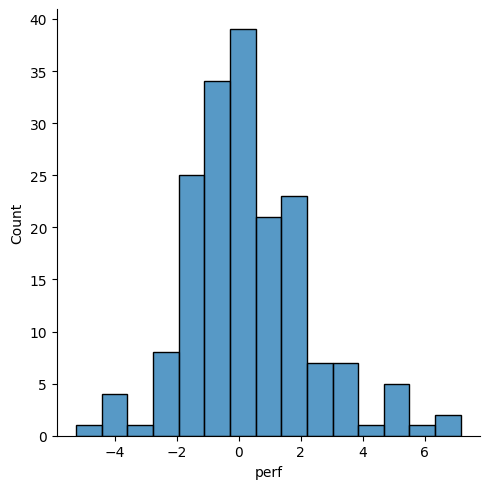

In [151]:
sns.displot(
    x='perf',
    data=summary_2022,
    kind="hist",
    bins=15
)

In [152]:
summary_2022['perf'].describe()

count    179.000000
mean       0.269904
std        2.001832
min       -5.259571
25%       -0.909880
50%       -0.008882
75%        1.405631
max        7.171823
Name: perf, dtype: float64

The above analysis shows a distribution that is 

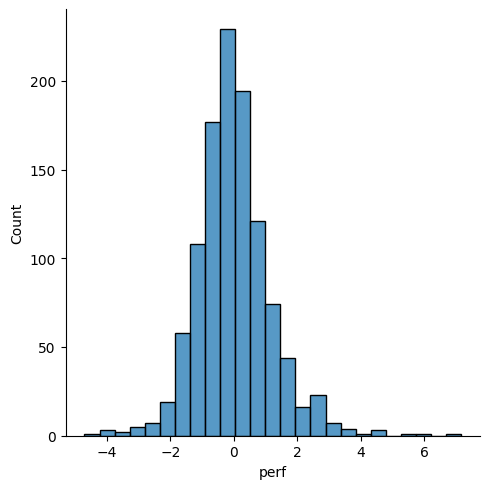

In [156]:
# Use regression line on original dataset with all values 
df_avg_final['expected_fantasy_pts'] = lin_func_fpts(df_avg_final['avg_tgt_share'])
df_avg_final['perf'] = df_avg_final['avg_fantasy_pts'] - df_avg_final['expected_fantasy_pts']

sns.displot(
    x='perf',
    data=df_avg_final,
    kind="hist",
    bins=25
)

In [159]:
df_avg_final['perf'].describe().apply(lambda x: format(x, 'f'))

count    1099.000000
mean        0.000000
std         1.169092
min        -4.703213
25%        -0.668248
50%        -0.099778
75%         0.580210
max         7.171823
Name: perf, dtype: object

The observed expected points differential from 1999-2021 is normally distributed with a mean of 0 and standard deviation of 1.169. Therefore we would expect the sample population of player averages for 2022 to be normally distributed as well and thus we should be able to compute the likelihood of a player finishing with that expected point differential (actual - expected) using statistical methods. 

In [164]:
import scipy.stats

scipy.stats.norm(
    summary_2022['perf'].mean(),
    summary_2022['perf'].std()
).cdf(summary_2022[summary_2022['player_name'] == 'Davante Adams']['perf'])

array([0.6230966])

# Score out original dataset